<a href="https://colab.research.google.com/github/M-McKegney/ET5003_SEM1_2021-2/blob/MMcKegneyBranch/ET5003_Etivity2_MichaelMcKegney_20149743.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Student Name: Michael McKegney**

## **Student ID: 20149743**

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1833]:
#@title Current Date
Today = '2021-10-01' #@param {type:"date"}


In [1834]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20149743" #@param {type:"string"}
Student_full_name = "Michael McKegney" #@param {type:"string"}
#@markdown ---

In [1835]:
#@title Notebook information
Notebook_type = 'Example' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [1836]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [1837]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [1838]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [1839]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Read in the dataset

The data is relation to the research paper by Ahtesham *et al*. (2020).

**Be careful with the 'Path' location shown below i.e. make sure it is pointing to where you store the data for Etivity 2!**

The following code is being used to determine if a Jupyter Notebook or Google Colab environment is being used to load the dataset.

The development work for this Etivity was done in Google Colab.

There are 3 files to account for:
*   house_train.csv
*   house_test.csv
*   true_price.csv

In [1840]:
# Checking if you are using Google Colab.

RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # paste the path here, keep quotation marks and the trailing slash
    Path = '/content/drive/MyDrive/UL_Colab_Files/ET5003/Etivity2/'
    
else:
    
    Path = './Etivity2/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read in each ".csv" file into a Pandas dataframe and print the shape of the data.

In [1841]:
# Training Dataset: 
training_file = Path + 'house_train.csv'
dftrain = pd.read_csv(training_file)
print('House train data shape: ', dftrain.shape)

# Test Dataset:
testing_file = Path + 'house_test.csv'
dftest = pd.read_csv(testing_file)
print('House test data shape: ', dftest.shape)

# Cost Dataset:
cost_file = Path + 'true_price.csv'
dfcost = pd.read_csv(cost_file)
print('True price data shape: ', dfcost.shape)


House train data shape:  (2982, 17)
House test data shape:  (500, 16)
True price data shape:  (500, 2)


Check the initial rows and review some basic statistics for each dataframe.

# METHOD

## Training & Test Data

**Not using this for now...**

In [1842]:
# # split data into training and test
# from sklearn.model_selection import train_test_split

# # training: 70% (0.7), test: 30% (0.3) 
# # you could try any other combination 
# # but consider 50% of training as the low boundary
# X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

### Train dataset

In [1843]:
# Show first data frame rows.
dftrain.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [1844]:
# Generate descriptive statistics.
dftrain.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


Assess count of each feature alongside the data type i.e. whether it is numeric or categorical.

In [1845]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2982 entries, 0 to 2981
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ad_id               2982 non-null   int64  
 1   area                2982 non-null   object 
 2   bathrooms           2931 non-null   float64
 3   beds                2931 non-null   float64
 4   ber_classification  2305 non-null   object 
 5   county              2982 non-null   object 
 6   description_block   2982 non-null   object 
 7   environment         2982 non-null   object 
 8   facility            965 non-null    object 
 9   features            2982 non-null   object 
 10  latitude            2982 non-null   float64
 11  longitude           2982 non-null   float64
 12  no_of_units         59 non-null     float64
 13  price               2892 non-null   float64
 14  property_category   2982 non-null   object 
 15  property_type       2931 non-null   object 
 16  surfac

Check each column in the dataframe how many null/Nan instances there are.

In [1846]:
dftrain.isna().sum()

ad_id                    0
area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
description_block        0
environment              0
facility              2017
features                 0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

There is 2982 rows and 17 columns in the training data. 
*   '**facility**' has 2017 NaN instances which means there is nearly two thirds of values missing. 
*   '**no_of_units**' has 2923 NaN instances which means there is nearly all values missing.
*   '**ad_id**' has 2982 unique values which equates to the total amount of rows so it is not offering any helpful information.
*   '**description_block**' and '**features**' have sentences/statements with inconsistent descriptions about the properties so these are not helpful for training a model. 

These features will be dropped as there is not much value being added in terms of training a model with them.




In [1847]:
dftrain_adj = dftrain.drop(columns=['ad_id', 'facility','no_of_units', 'description_block', 'features'])

dftrain_adj.shape

(2982, 12)

Check how much variation there is in the features '**county**', '**environment**' and '**property_category**'.

In [1848]:
dftrain_adj['county'].value_counts()

Dublin    2982
Name: county, dtype: int64

In [1849]:
dftrain_adj['environment'].value_counts()

prod    2982
Name: environment, dtype: int64

In [1850]:
dftrain_adj['property_category'].value_counts()

sale                      2923
new_development_parent      59
Name: property_category, dtype: int64

As '**county**' has only one value 'Dublin' and '**environment**' has only one value 'prod', these features can be removed as they are not providing any useful information. 

Only 59 out of 2982 instances (~2%) of '**property_category**' are not 'sale' so this feature is not adding a lot of information either and can be removed too.

In [1851]:
dftrain_adj.drop(columns=['county', 'environment', 'property_category'], inplace=True)

In [1852]:
dftrain_adj.shape

(2982, 9)

Drop all rows with NaN present as the sample/observation is incomplete and may be misleading.

In [1853]:
dftrain_adj.dropna(inplace=True)

dftrain_adj.shape

(2002, 9)

Remove samples where there are 0 bathrooms and 0 bedrooms.

In [1854]:
dftrain_adj.drop(dftrain_adj[dftrain_adj.beds == 0].index, inplace=True)

dftrain_adj.drop(dftrain_adj[dftrain_adj.bathrooms == 0].index, inplace=True)

dftrain_adj.shape

(1989, 9)

Check what features remain.

In [1855]:
dftrain_adj.head()

,area,bathrooms,beds,ber_classification,latitude,longitude,price,property_type,surface
15,Clonee,3.0,5.0,A3,53.400454,-6.445730,935000.0,detached,321.0
26,Clondalkin,4.0,4.0,A3,53.316410,-6.385214,485000.0,semi-detached,144.0
27,Clonee,3.0,5.0,A3,53.401414,-6.446634,935000.0,detached,321.0
35,Howth,5.0,5.0,A2,53.375377,-6.056749,1475000.0,detached,312.0
38,Castleknock,2.0,2.0,A3,53.372130,-6.338466,410000.0,apartment,83.0


In [1856]:
dftrain_adj['area'].value_counts()

Rathfarnham    73
Castleknock    67
Malahide       57
Lucan          55
Blackrock      51
               ..
Kilmore         1
Kiltipper       1
Greenhills      1
Kingswood       1
Garristown      1
Name: area, Length: 144, dtype: int64

In [1857]:
temporary_series = dftrain_adj['area'].value_counts()

temporary_series.values

array([73, 67, 57, 55, 51, 45, 41, 39, 39, 38, 37, 37, 36, 36, 34, 33, 33,
       33, 32, 30, 29, 29, 26, 26, 25, 24, 24, 24, 24, 22, 22, 21, 20, 20,
       19, 18, 18, 17, 17, 16, 16, 16, 16, 16, 15, 15, 14, 13, 13, 13, 13,
       13, 13, 13, 13, 12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 10,
       10,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  7,
        7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  5,  5,  5,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1])

In [1858]:
dftrain_adj['ber_classification'].value_counts()

D1                     255
D2                     241
C3                     224
C2                     210
C1                     182
E1                     154
E2                     148
G                      144
F                      135
B3                     106
B2                      69
A3                      61
SINo666of2006exempt     23
A2                      22
B1                      14
A1                       1
Name: ber_classification, dtype: int64

In [1859]:
dftrain_adj['property_type'].value_counts()

semi-detached     554
apartment         530
terraced          339
detached          297
end-of-terrace    153
bungalow           56
duplex             37
townhouse          19
site                3
studio              1
Name: property_type, dtype: int64

For the categorical features '**area**', '**ber_classification**' and '**property_type**' a mapping approach will be taken to convert these to numerical features going forward.

The approach shown below was adapted from datacamp.com by Pathak (2020) which displays a very helpful way of mapping categorical features to numerical features without having to explicitly state the mapping yourself.


Convert each categorical variable in turn and update dataframe.

In [1860]:
labels = dftrain_adj['area'].astype('category').cat.categories.tolist()

replace_map_comp_1 = {'area' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print(replace_map_comp_1)

dftrain_adj.replace(replace_map_comp_1, inplace=True)

{'area': {'Adamstown': 1, 'Ard Na Greine': 2, 'Artane': 3, 'Ashtown': 4, 'Balbriggan': 5, 'Baldoyle': 6, 'Balgriffin': 7, 'Ballinteer': 8, 'Ballsbridge': 9, 'Ballybough': 10, 'Ballyboughal': 11, 'Ballybrack': 12, 'Ballycullen': 13, 'Ballyfermot': 14, 'Ballymun': 15, 'Balrothery': 16, 'Beaumont': 17, 'Blackrock': 18, 'Blanchardstown': 19, 'Bluebell': 20, 'Booterstown': 21, 'Brittas': 22, 'Cabinteely': 23, 'Cabra': 24, 'Carrickmines': 25, 'Castleknock': 26, 'Chapelizod': 27, 'Christchurch': 28, 'Churchtown': 29, 'Citywest': 30, 'Clarehall': 31, 'Clondalkin': 32, 'Clonee': 33, 'Clongriffin': 34, 'Clonshaugh': 35, 'Clonsilla': 36, 'Clonskeagh': 37, 'Clontarf': 38, 'Coolock': 39, 'Crumlin': 40, 'Dalkey': 41, 'Darndale': 42, 'Dartry': 43, 'Donabate': 44, 'Donaghmede': 45, 'Donnybrook': 46, 'Donnycarney': 47, 'Drimnagh': 48, 'Drumcondra': 49, 'Dublin 1': 50, 'Dublin 2': 51, 'Dublin 4': 52, 'Dublin 7': 53, 'Dublin 8': 54, 'Dun Laoghaire': 55, 'Dundrum': 56, 'East Wall': 57, 'Edenmore': 58, 'Fa

In [1861]:
labels = dftrain_adj['ber_classification'].astype('category').cat.categories.tolist()

replace_map_comp_2 = {'ber_classification' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print(replace_map_comp_2)

dftrain_adj.replace(replace_map_comp_2, inplace=True)

{'ber_classification': {'A1': 1, 'A2': 2, 'A3': 3, 'B1': 4, 'B2': 5, 'B3': 6, 'C1': 7, 'C2': 8, 'C3': 9, 'D1': 10, 'D2': 11, 'E1': 12, 'E2': 13, 'F': 14, 'G': 15, 'SINo666of2006exempt': 16}}


In [1862]:
labels = dftrain_adj['property_type'].astype('category').cat.categories.tolist()

replace_map_comp_3 = {'property_type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print(replace_map_comp_3)

dftrain_adj.replace(replace_map_comp_3, inplace=True)

{'property_type': {'apartment': 1, 'bungalow': 2, 'detached': 3, 'duplex': 4, 'end-of-terrace': 5, 'semi-detached': 6, 'site': 7, 'studio': 8, 'terraced': 9, 'townhouse': 10}}


In [1863]:
dftrain_adj.head()

,area,bathrooms,beds,ber_classification,latitude,longitude,price,property_type,surface
15,33,3.0,5.0,3,53.400454,-6.445730,935000.0,3,321.0
26,32,4.0,4.0,3,53.316410,-6.385214,485000.0,6,144.0
27,33,3.0,5.0,3,53.401414,-6.446634,935000.0,3,321.0
35,70,5.0,5.0,2,53.375377,-6.056749,1475000.0,3,312.0
38,26,2.0,2.0,3,53.372130,-6.338466,410000.0,1,83.0


In [1864]:
dftrain_adj.shape

(1989, 9)

Now all training features are now numeric. There are 9 remaining features (which includes the target 'price').

### Test dataset

The same pre-processing approaches taken on the training dataset will be taken on the test dataset.

In [1865]:
# Show first data frame rows.
dftest.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0


In [1866]:
# Generate descriptive statistics.
dftest.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,surface
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,0.0,500.000000
mean,1.231695e+07,1.994000,2.930000,53.356034,-6.247842,NaN,156.007671
std,1.485832e+05,1.106532,1.191612,0.081905,0.088552,NaN,344.497362
min,1.130615e+07,0.000000,0.000000,53.221348,-6.496987,NaN,33.500000
25%,1.228617e+07,1.000000,2.000000,53.297373,-6.296404,NaN,72.375000
50%,1.237964e+07,2.000000,3.000000,53.339547,-6.243572,NaN,98.000000
75%,1.240544e+07,3.000000,4.000000,53.381650,-6.185055,NaN,138.935000
max,1.242809e+07,8.000000,7.000000,53.619775,-6.064874,NaN,5746.536120


The 'dfcost' data will temporarily be appended to the test dataset to ensure any pre-processing steps effects 'dftest' and 'dfcost' similarly.

In [1867]:
dfcost.shape

(500, 2)

Get rid of the ID column as that is already present in the test datset.

In [1868]:
dfcost_temp = dfcost.drop(columns='Id')
dfcost_temp.shape
#dfcost_temp

(500, 1)

In [1869]:
dftest_adj = pd.concat([dftest, dfcost_temp], axis=1)
dftest_adj.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface,Expected
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0,875000.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0,355000.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0,440000.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4,425000.0
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0,265000.0


Drop columns=['ad_id', 'facility','no_of_units', 'description_block', 'features'] like was done in the training set.

In [1870]:
dftest_adj = dftest_adj.drop(columns=['ad_id', 'facility','no_of_units', 'description_block', 'features'])

dftest_adj.shape

(500, 12)

Drop columns=['county', 'environment', 'property_category'] like was done in the training set.

In [1871]:
dftest_adj.drop(columns=['county', 'environment', 'property_category'], inplace=True)

dftest_adj.shape

(500, 9)

Drop all rows with NaN present as the sample/observation is incomplete and may be misleading.

In [1872]:
dftest_adj.dropna(inplace=True)

dftest_adj.shape

(444, 9)

Remove samples where there are 0 bathrooms and 0 bedrooms.

In [1873]:
dftest_adj.drop(dftest_adj[dftest_adj.beds == 0].index, inplace=True)

dftest_adj.drop(dftest_adj[dftest_adj.bathrooms == 0].index, inplace=True)

dftest_adj.shape

(440, 9)

Convert each categorical variable ('area', 'ber_classification' & 'property_type') in turn and update dataframe. Use the same mapping as in the training dataset pre-processing.

**In the training set there is no instance of 'Kilbarrack' for the 'area' feature but in the test data there is. This subsequently will cause a 'ValueError: could not convert string to float: 'Kilbarrack'' error later in the piecewise linear regression code if not removed now.**

**In the training data there is also only a single instance of 'Deansgrange' was removed in my pre-processing approach so is removed in the test data too.**

In [1874]:
# 'kilbarrack' doesn't exist in the training data but does in the test data so should be removed.
dftest_adj.drop(dftest_adj[dftest_adj.area == 'Kilbarrack'].index, inplace=True)     # Prevents later instance of: ValueError: could not convert string to float: 'Kilbarrack'

# Removing 'Deansgrange' from the test data too as it was removed in the training data pre-processing.
dftest_adj.drop(dftest_adj[dftest_adj.area == 'Deansgrange'].index, inplace=True)     # Prevents later instance of: ValueError: could not convert string to float: 'Deansgrange'

dftest_adj.shape

# for each_element in dftest_adj['area']:

#   print(each_element)

(438, 9)

In [1875]:
print(replace_map_comp_1)

dftest_adj.replace(replace_map_comp_1, inplace=True)

{'area': {'Adamstown': 1, 'Ard Na Greine': 2, 'Artane': 3, 'Ashtown': 4, 'Balbriggan': 5, 'Baldoyle': 6, 'Balgriffin': 7, 'Ballinteer': 8, 'Ballsbridge': 9, 'Ballybough': 10, 'Ballyboughal': 11, 'Ballybrack': 12, 'Ballycullen': 13, 'Ballyfermot': 14, 'Ballymun': 15, 'Balrothery': 16, 'Beaumont': 17, 'Blackrock': 18, 'Blanchardstown': 19, 'Bluebell': 20, 'Booterstown': 21, 'Brittas': 22, 'Cabinteely': 23, 'Cabra': 24, 'Carrickmines': 25, 'Castleknock': 26, 'Chapelizod': 27, 'Christchurch': 28, 'Churchtown': 29, 'Citywest': 30, 'Clarehall': 31, 'Clondalkin': 32, 'Clonee': 33, 'Clongriffin': 34, 'Clonshaugh': 35, 'Clonsilla': 36, 'Clonskeagh': 37, 'Clontarf': 38, 'Coolock': 39, 'Crumlin': 40, 'Dalkey': 41, 'Darndale': 42, 'Dartry': 43, 'Donabate': 44, 'Donaghmede': 45, 'Donnybrook': 46, 'Donnycarney': 47, 'Drimnagh': 48, 'Drumcondra': 49, 'Dublin 1': 50, 'Dublin 2': 51, 'Dublin 4': 52, 'Dublin 7': 53, 'Dublin 8': 54, 'Dun Laoghaire': 55, 'Dundrum': 56, 'East Wall': 57, 'Edenmore': 58, 'Fa

In [1876]:
print(replace_map_comp_2)

dftest_adj.replace(replace_map_comp_2, inplace=True)

{'ber_classification': {'A1': 1, 'A2': 2, 'A3': 3, 'B1': 4, 'B2': 5, 'B3': 6, 'C1': 7, 'C2': 8, 'C3': 9, 'D1': 10, 'D2': 11, 'E1': 12, 'E2': 13, 'F': 14, 'G': 15, 'SINo666of2006exempt': 16}}


In [1877]:
print(replace_map_comp_3)

dftest_adj.replace(replace_map_comp_3, inplace=True)

{'property_type': {'apartment': 1, 'bungalow': 2, 'detached': 3, 'duplex': 4, 'end-of-terrace': 5, 'semi-detached': 6, 'site': 7, 'studio': 8, 'terraced': 9, 'townhouse': 10}}


In [1878]:
dftest_adj.head()

,area,bathrooms,beds,ber_classification,latitude,longitude,property_type,surface,Expected
0,128,2.0,4.0,15,53.566881,-6.101148,2,142.0,875000.0
1,90,2.0,3.0,7,53.362992,-6.452909,9,114.0,355000.0
2,134,3.0,4.0,6,53.454198,-6.262964,6,172.0,440000.0
3,90,4.0,3.0,3,53.354402,-6.458647,6,132.4,425000.0
4,32,1.0,3.0,13,53.336530,-6.393587,6,88.0,265000.0


In [1879]:
dftest_adj.shape

(438, 9)

Now all test features are now numeric. There are 9 remaining features (which includes the target 'price').

### Expected Cost dataset

In [1880]:
cost_data = [dftest_adj['Expected']]

header_name = ['cost']    # ['Expected']

dfcost_adj = pd.concat(cost_data, axis=1, keys=header_name)

dftest_adj.drop(columns='Expected', inplace=True)

dfcost_adj.shape

(438, 1)

In [1881]:
dftest_adj.shape

(438, 8)

In [1882]:
# Show first data frame rows.
dfcost_adj.head()

,cost
0,875000.0
1,355000.0
2,440000.0
3,425000.0
4,265000.0


In [1883]:
# Generate descriptive statistics.
dfcost_adj.describe()

,cost
count,4.380000e+02
mean,5.441125e+05
std,4.719529e+05
min,1.250000e+05
25%,2.950000e+05
50%,4.225000e+05
75%,5.950000e+05
max,5.250000e+06


# PIECEWISE REGRESSION

## Full Model

In [1884]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = ['area',	'bathrooms',	'beds',	'ber_classification',	'latitude',	'longitude',	'price',	'property_type',	'surface']
# dropna: remove missing values
df_subset_train = dftrain_adj[featrain].dropna(axis=0)

featest = ['area',	'bathrooms',	'beds',	'ber_classification',	'latitude',	'longitude',	'property_type',	'surface']
df_subset_test  =  dftest_adj[featest].dropna(axis=0)

# cost
df_cost = dfcost_adj[dfcost_adj.index.isin(df_subset_test.index)]

In [1885]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_cost.cost.values

In [1886]:
df_subset_test

,area,bathrooms,beds,ber_classification,latitude,longitude,property_type,surface
0,128,2.0,4.0,15,53.566881,-6.101148,2,142.0
1,90,2.0,3.0,7,53.362992,-6.452909,9,114.0
2,134,3.0,4.0,6,53.454198,-6.262964,6,172.0
3,90,4.0,3.0,3,53.354402,-6.458647,6,132.4
4,32,1.0,3.0,13,53.336530,-6.393587,6,88.0
...,...,...,...,...,...,...,...,...
494,9,2.0,3.0,10,53.327531,-6.238508,1,116.6
496,23,3.0,5.0,12,53.261475,-6.147720,3,191.3
497,3,1.0,3.0,15,53.391619,-6.205157,3,105.0
498,38,2.0,4.0,13,53.360578,-6.183701,5,130.0


In [1887]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

#Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
Xss_train = Xs_train.copy()
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

#Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xss_test = Xs_test.copy()
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [1888]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 1,715.6


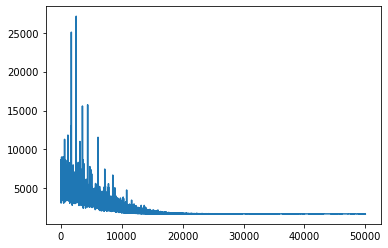

In [1889]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [1890]:
# samples from the posterior
posterior = approximation.sample(5000)

In [1891]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  547441.2767773318
MAPE =  1.008612312851013


## Clustering

### Full Model

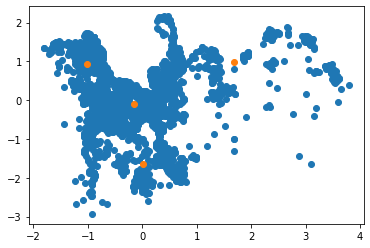

In [1892]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)

# Choosing features 4 & 5 which relate to longitude and latitude.
ind=[4,5]

X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

In [1893]:
np.max(ys_train)

72236.38713984

### Clusters

In [1894]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))


{0: 318, 1: 1015, 2: 298, 3: 358}

In [1895]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 59, 1: 229, 2: 71, 3: 79}

In [1896]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)


In [1897]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [1898]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)


In [1899]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

## Piecewise Model

In [1900]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 406.83


In [1901]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 867.19


In [1902]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 185.74


In [1903]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 293.67


In [1904]:
#############

In [1905]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred



##Simulations

### Only Cluster 0

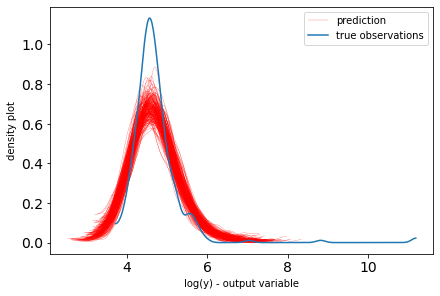

In [1906]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 1

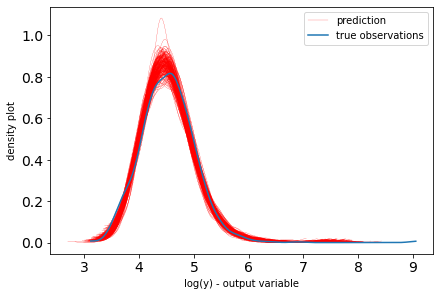

In [1907]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 2

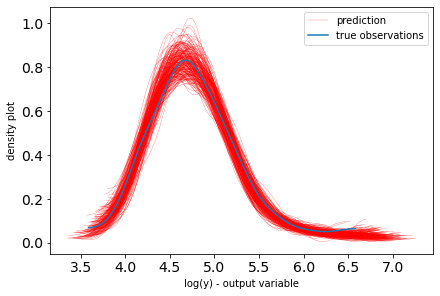

In [1908]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 3

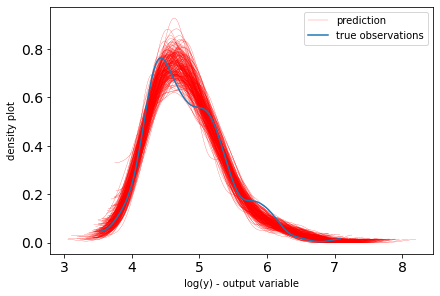

In [1909]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

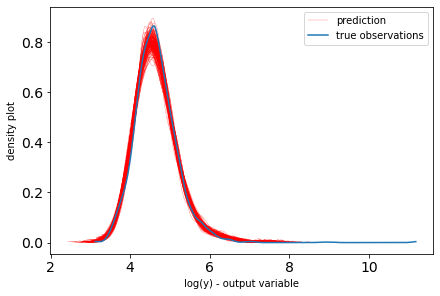

In [1910]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [1911]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 59 , MAE Cluster0= 387513.123383088
Size Cluster1 229 , MAE Cluster1= 721225.852298547
Size Cluster2 71 , MAE Cluster2= 456158.86556712864
Size Cluster3 79 , MAE Cluster3= 758382.968250976
MAE= 640008.055714755


### PPC on the Test set



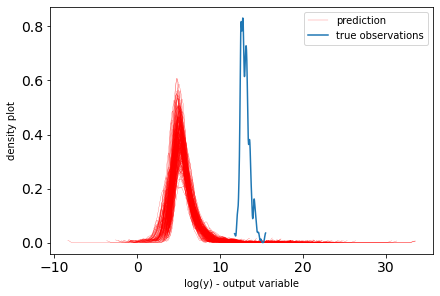

In [1912]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# SUMMARY



### **Pre-processing:**

The pre-processing effort on this Etivity took longer than anticipated. There was 2982 rows and 17 columns in the training data to begin with. 

The following steps were taken in the end:
*   '**facility**' has 2017 NaN instances which means there is nearly two thirds of values missing. The feature was dropped.
*   '**no_of_units**' has 2923 NaN instances which means there is nearly all values missing. The feature was dropped.
*   '**ad_id**' has 2982 unique values which equates to the total amount of rows so it is not offering any helpful information. The feature was dropped.
*   '**description_block**' and '**features**' have sentences/statements with inconsistent descriptions about the properties so these are not helpful for training a model. The features were dropped.
*   As '**county**' has only one value 'Dublin' and '**environment**' has only one value 'prod', these features can be removed as they are not providing any useful information.
*   Only 59 out of 2982 instances (~2%) of '**property_category**' are not 'sale' so this feature is not adding a lot of information either and can be removed too.
*   Drop all rows with NaN present as the sample/observation is incomplete and may be misleading when training a model.
*   Samples where there are 0 bathrooms and 0 bedrooms were removed as per instruction/statement in Etivity description.
*   For the categorical features '**area**', '**ber_classification**' and '**property_type**' a mapping approach will be taken to convert these to numerical features going forward.
    *    A very helpful approach on this was adapted from code available by Pathak (2020) on the datacamp.com site.
*   In the training set there is no instance of '*Kilbarrack*' for the '**area**' feature but in the test data there is. This subsequently will cause a 'ValueError: could not convert string to float: '*Kilbarrack*'' error later in the piecewise linear regression code if not removed now.
*   In the training data there is also only a single instance of '*Deansgrange*' for the '**area**' feature and it was removed in my pre-processing approach so it was subsequently removed in the test data too as the model would have had no instance to train on.

The pre-processing done to the training set was also carried out to the test set (which temporarily was made include the 'cost' data to ensure the pre-processing effects were uniform throughout).

There ended up being **9 features retained in the training and test data**.
*   The training data had 1989 rows in the end.
*   The testing data had 438 rows in the end.

### **Full Model:**

Example values of MAE (Mean Absolute Error) & MAPE (Mean Absolute Percentage Error) I’m seeing are as follows:
*   MAE =  551667.1480636544
*   MAPE =  1.0193380860536665

### **Clustering:**

Initially I have stuck with 4 clusters similar to the lab notebook. A model was applied to each cluster. Example results are as follows:
*   Model 0 Average Loss = 406.76
*   Model 1 Average Loss = 293.56
*   Model 2 Average Loss = 185.82
*   Model 3 Average Loss = 867.3

### **Simulations:**

The PPC (Posterior Predictive Checks) function is used in this section of the code.

There can be some run-to-run variation but typically I'm seeing that for 3 out of 4 cluster plots the predictions and true observations relatively align. On one of the cluster plots, the predictions undershoot the peak of the true observations by a value of about 0.2 on the vertical (density) axis.

The predictions and true observations align well on the "overall" plot.

### **Test Set Data:**

Example results from checking the test set data is as follows:
*   MAE Cluster0= 387528.07527253893
*   MAE Cluster1= 758395.5982165106
*   MAE Cluster2= 458255.9346318
*   MAE Cluster3= 693896.2910986621
*   MAE Joint = 626063.540458072

The PPC related plot of density vs log(y) shows a mismatch of the distributions for predictions & true observations. I need to look into this further.


# REFERENCES




Ahtesham, M., Bawany, N. Z. and Fatima, K. (2020) 'House Price Prediction using Machine Learning Algorithm - The Case of Karachi City, Pakistan', *2020 21st International Arab Conference on Information Technology (ACIT)*, 1-5, available: https://doi.org/10.1109/ACIT50332.2020.9300074.



Pathak, M. (2020) *Handling Categorical Data in Python*, datacamp.com, available: https://www.datacamp.com/community/tutorials/categorical-data#encoding [accessed 1 Oct 2021].